# U-Net Retina Blood Vessel Segmentation

## Imports and paths

In [10]:
import os
import glob
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Paths from your updated cell
print("Paths being used:")
print("train_img_path:", train_img_path)
print("train_mask_path:", train_mask_path)
print("test_img_path:", test_img_path)
print("test_mask_path:", test_mask_path)

# list files
train_imgs = sorted(glob.glob(os.path.join(train_img_path, "*.*")))
train_masks = sorted(glob.glob(os.path.join(train_mask_path, "*.*")))
test_imgs = sorted(glob.glob(os.path.join(test_img_path, "*.*")))
test_masks = sorted(glob.glob(os.path.join(test_mask_path, "*.*")))

print(f"Train images found: {len(train_imgs)}")
print(f"Train masks found: {len(train_masks)}")
print(f"Test images found : {len(test_imgs)}")
print(f"Test masks found : {len(test_masks)}")

# quick pair check by basename presence to avoid wrong ordering
def pair_check(img_list, mask_list):
    img_basenames = {os.path.basename(p) for p in img_list}
    mask_basenames = {os.path.basename(p) for p in mask_list}
    inter = img_basenames & mask_basenames
    return len(inter), len(img_basenames), len(mask_basenames)

inter_train, ni, nm = pair_check(train_imgs, train_masks)
inter_test, nti, ntm = pair_check(test_imgs, test_masks)
print(f"Train basename matches: {inter_train}/{len(train_imgs)}")
print(f"Test  basename matches: {inter_test}/{len(test_imgs)}")
if inter_train == 0:
    raise RuntimeError("No matching basenames between train images and masks. Fix filenames or folder content.")

Paths being used:
train_img_path: /kaggle/input/retina-blood-vessel/Data/train/image
train_mask_path: /kaggle/input/retina-blood-vessel/Data/train/mask
test_img_path: /kaggle/input/retina-blood-vessel/Data/test/image
test_mask_path: /kaggle/input/retina-blood-vessel/Data/test/mask
Train images found: 80
Train masks found: 80
Test images found : 20
Test masks found : 20
Train basename matches: 80/80
Test  basename matches: 20/20


## EDA: sizes and mask coverage

Train image sizes count: [((512, 512), 80)]
Test image sizes count: [((512, 512), 20)]
Mask coverage sample stats -> min 0.060059, max 0.115013, mean 0.087371


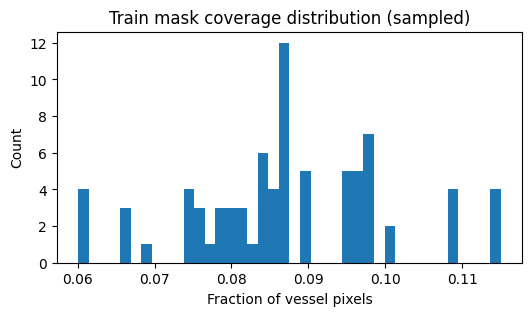

In [11]:
# EDA: image sizes and mask coverage distribution
def img_size_list(paths):
    sizes = [Image.open(p).size for p in paths]
    return Counter(sizes)

print("Train image sizes count:", img_size_list(train_imgs).most_common()[:10])
print("Test image sizes count:", img_size_list(test_imgs).most_common()[:10])

def mask_coverage(mask_path):
    m = np.array(Image.open(mask_path).convert("L"))
    return (m > 127).sum() / m.size

sample_n = min(300, len(train_masks))
sample_indices = random.sample(range(len(train_masks)), sample_n)
coverages = [mask_coverage(train_masks[i]) for i in sample_indices]
print("Mask coverage sample stats -> min {:.6f}, max {:.6f}, mean {:.6f}".format(min(coverages), max(coverages), np.mean(coverages)))

plt.figure(figsize=(6,3))
plt.hist(coverages, bins=40)
plt.title("Train mask coverage distribution (sampled)")
plt.xlabel("Fraction of vessel pixels")
plt.ylabel("Count")
plt.show()

## Show example images and overlays

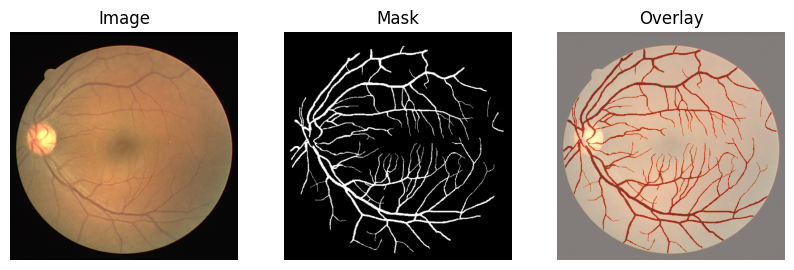

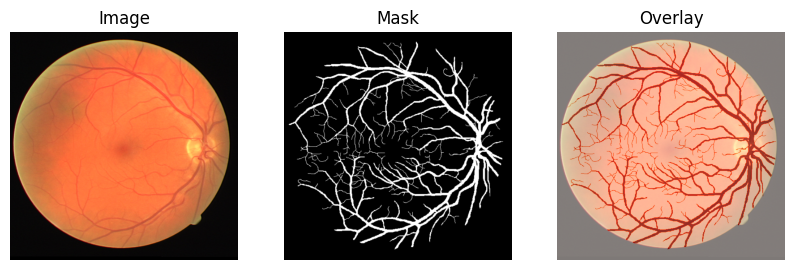

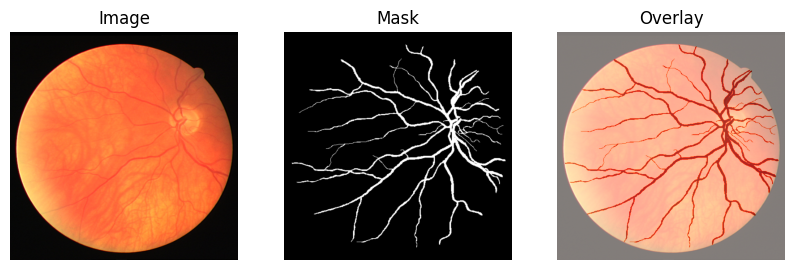

In [12]:
# helper function to plot image, mask, overlay
def show_image_mask(img_path, mask_path, alpha=0.5):
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img); plt.imshow(mask, cmap="Reds", alpha=alpha); plt.title("Overlay"); plt.axis("off")
    plt.show()

# show three random training samples
for i in random.sample(range(len(train_imgs)), min(3, len(train_imgs))):
    # find corresponding mask by basename
    base = os.path.basename(train_imgs[i])
    mask_candidate = os.path.join(train_mask_path, base)
    if not os.path.exists(mask_candidate):
        # fallback to same index pairing if names differ
        mask_candidate = train_masks[i] if i < len(train_masks) else train_masks[0]
    show_image_mask(train_imgs[i], mask_candidate)

# Dataset class and pairing by basename

In [13]:
# Dataset that pairs images and masks by basename
class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, keys=None, augment=False, resize=None):
        # build mapping from basename -> path
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augment = augment
        self.resize = resize

        image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
        mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.*")))

        # build dicts
        self.img_map = {os.path.basename(p): p for p in image_paths}
        self.mask_map = {os.path.basename(p): p for p in mask_paths}

        if keys is None:
            # intersection basenames
            keys = sorted(list(set(self.img_map.keys()) & set(self.mask_map.keys())))
        self.keys = keys
        if len(self.keys) == 0:
            raise RuntimeError("No matching image-mask basenames found in dataset dirs.")

    def __len__(self):
        return len(self.keys)

    def _random_transform(self, img, mask):
        if random.random() < 0.5:
            img = TF.hflip(img); mask = TF.hflip(mask)
        if random.random() < 0.5:
            img = TF.vflip(img); mask = TF.vflip(mask)
        if random.random() < 0.5:
            angle = random.choice([0,90,180,270])
            img = TF.rotate(img, angle); mask = TF.rotate(mask, angle)
        return img, mask

    def __getitem__(self, idx):
        basename = self.keys[idx]
        img = Image.open(self.img_map[basename]).convert("RGB")
        mask = Image.open(self.mask_map[basename]).convert("L")
        if self.resize:
            img = img.resize(self.resize, resample=Image.BILINEAR)
            mask = mask.resize(self.resize, resample=Image.NEAREST)
        if self.augment:
            img, mask = self._random_transform(img, mask)

        img = np.array(img).astype(np.float32) / 255.0
        mask = (np.array(mask).astype(np.float32) > 127).astype(np.float32)

        img = torch.tensor(img.transpose(2,0,1), dtype=torch.float32)
        mask = torch.tensor(mask[np.newaxis,:,:], dtype=torch.float32)

        # change here if your training used normalization
        return img, mask

## Build train/val splits and DataLoaders

Total train pairs: 72, val pairs: 8
Preview batch shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


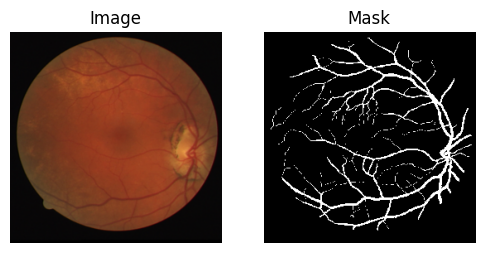

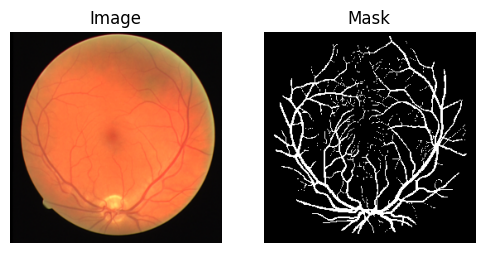

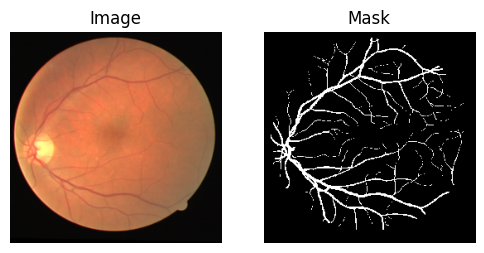

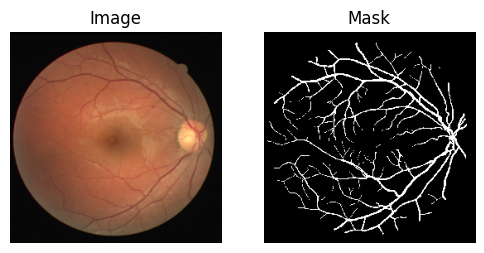

In [34]:
# choose resize; set to the size your original model used
resize = (256, 256)  # change to original training size if different

# build dataset keys using intersection
all_keys = sorted(list(set(os.listdir(train_img_path)) & set(os.listdir(train_mask_path))))
random.shuffle(all_keys)

val_frac = 0.1
val_count = max(1, int(len(all_keys) * val_frac))
train_keys = all_keys[:-val_count]
val_keys = all_keys[-val_count:]

print(f"Total train pairs: {len(train_keys)}, val pairs: {len(val_keys)}")

train_ds = RetinaDataset(train_img_path, train_mask_path, keys=train_keys, augment=True, resize=resize)
val_ds = RetinaDataset(train_img_path, train_mask_path, keys=val_keys, augment=False, resize=resize)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# preview a batch
imgs, msks = next(iter(train_loader))
print("Preview batch shapes:", imgs.shape, msks.shape)

def show_batch(imgs, msks, n=4):
    imgs_np = imgs.numpy()
    msks_np = msks.numpy()
    for i in range(min(n, imgs_np.shape[0])):
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1); plt.imshow(imgs_np[i].transpose(1,2,0)); plt.axis("off"); plt.title("Image")
        plt.subplot(1,2,2); plt.imshow(msks_np[i,0], cmap="gray"); plt.axis("off"); plt.title("Mask")
        plt.show()

show_batch(imgs, msks, n=4)

## U-Net model

In [35]:
# Standard U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups = nn.ModuleList()
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(f*2, f))
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        skips = skips[::-1]
        for idx in range(0, len(self.ups), 2):
            upconv = self.ups[idx]
            dconv = self.ups[idx+1]
            x = upconv(x)
            skip = skips[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = dconv(x)
        return self.final(x)

## Loss and metrics

In [36]:
# Cell No 8
# Loss and metric helpers

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = F.binary_cross_entropy_with_logits(logits, targets)
        smooth = 1.
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        intersection = (probs_flat * targets_flat).sum(1)
        dice = (2. * intersection + smooth) / (probs_flat.sum(1) + targets_flat.sum(1) + smooth)
        dice_loss = 1 - dice.mean()

        return bce + dice_loss


def compute_metrics(probs, targets, eps=1e-7):
    """
    Computes Dice, IoU, Precision, Recall, F1 and Accuracy for a batch.
    """
    probs_bin = (probs > 0.5).float()

    tp = (probs_bin * targets).sum(dim=(1,2,3))
    fp = (probs_bin * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - probs_bin) * targets).sum(dim=(1,2,3))
    tn = ((1 - probs_bin) * (1 - targets)).sum(dim=(1,2,3))

    precision = ((tp + eps) / (tp + fp + eps)).mean().item()
    recall = ((tp + eps) / (tp + fn + eps)).mean().item()
    f1 = (2 * precision * recall / (precision + recall + eps))
    acc = ((tp + tn + eps) / (tp + tn + fp + fn + eps)).mean().item()

    # Dice
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    dice = dice.mean().item()

    # IoU
    iou = ((tp + eps) / (tp + fp + fn + eps)).mean().item()

    return dice, iou, precision, recall, f1, acc

## Instantiate model, optimizer and scheduler

In [37]:
# Cell No 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(in_channels=3, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=4, verbose=True)
criterion = DiceBCELoss()

print(model)

Device: cuda
UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReL

## Training and validation loops

In [38]:
# Cell No 10
# Training and validation routines

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for imgs, masks in loader:
        imgs = imgs.to(device); masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    fps = len(loader.dataset) / (time.time() - start_time)
    return total_loss / len(loader.dataset), fps


@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    dices = []
    ious = []
    precs = []
    recalls = []
    f1s = []
    accs = []

    start_time = time.time()

    for imgs, masks in loader:
        imgs = imgs.to(device); masks = masks.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, masks)
        total_loss += loss.item() * imgs.size(0)

        probs = torch.sigmoid(outputs)
        d,i,p,r,f1,a = compute_metrics(probs, masks)

        dices.append(d)
        ious.append(i)
        precs.append(p)
        recalls.append(r)
        f1s.append(f1)
        accs.append(a)

    fps = len(loader.dataset) / (time.time() - start_time)

    return (
        total_loss / len(loader.dataset),
        np.mean(dices),
        np.mean(ious),
        np.mean(precs),
        np.mean(recalls),
        np.mean(f1s),
        np.mean(accs),
        fps
    )

## Run training or load existing best weights

In [39]:
num_epochs = 70
best_val_loss = float("inf")

history = {
    "train_loss":[], 
    "train_fps":[],
    "val_loss":[], 
    "val_dice":[], 
    "val_iou":[],
    "val_precision":[],
    "val_recall":[],
    "val_f1":[],
    "val_acc":[],
    "val_fps":[]
}

save_path = "/kaggle/working/best_unet.pth"

for epoch in range(1, num_epochs+1):

    train_loss, train_fps = train_epoch(model, train_loader, optimizer, criterion, device)
    
    (
        val_loss, val_dice, val_iou,
        val_precision, val_recall, val_f1, val_acc, val_fps
    ) = eval_epoch(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["train_fps"].append(train_fps)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)
    history["val_iou"].append(val_iou)
    history["val_precision"].append(val_precision)
    history["val_recall"].append(val_recall)
    history["val_f1"].append(val_f1)
    history["val_acc"].append(val_acc)
    history["val_fps"].append(val_fps)

    print(
        f"Epoch {epoch}/{num_epochs} "
        f"Train Loss: {train_loss:.4f} | FPS {train_fps:.2f} || "
        f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | "
        f"P: {val_precision:.4f} | R: {val_recall:.4f} | F1: {val_f1:.4f} | Acc: {val_acc:.4f} | "
        f"FPS {val_fps:.2f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model to", save_path)

Epoch 1/70 Train Loss: 1.4356 | FPS 33.78 || Val Loss: 1.5566 | Dice: 0.1829 | IoU: 0.1014 | P: 0.1095 | R: 0.7050 | F1: 0.1895 | Acc: 0.5396 | FPS 30.38
Saved best model to /kaggle/working/best_unet.pth
Epoch 2/70 Train Loss: 1.2133 | FPS 34.22 || Val Loss: 1.7077 | Dice: 0.1597 | IoU: 0.0873 | P: 0.0886 | R: 0.8200 | F1: 0.1599 | Acc: 0.3314 | FPS 30.88
Epoch 3/70 Train Loss: 1.0715 | FPS 33.88 || Val Loss: 1.2782 | Dice: 0.1223 | IoU: 0.0664 | P: 0.4770 | R: 0.0758 | F1: 0.1309 | Acc: 0.9206 | FPS 31.38
Saved best model to /kaggle/working/best_unet.pth
Epoch 4/70 Train Loss: 0.9533 | FPS 34.06 || Val Loss: 1.1504 | Dice: 0.3317 | IoU: 0.2081 | P: 0.6455 | R: 0.2728 | F1: 0.3835 | Acc: 0.9268 | FPS 30.61
Saved best model to /kaggle/working/best_unet.pth
Epoch 5/70 Train Loss: 0.8781 | FPS 33.97 || Val Loss: 1.0654 | Dice: 0.5775 | IoU: 0.4080 | P: 0.6222 | R: 0.5883 | F1: 0.6048 | Acc: 0.9359 | FPS 31.29
Saved best model to /kaggle/working/best_unet.pth
Epoch 6/70 Train Loss: 0.8181 

## Plot training curves

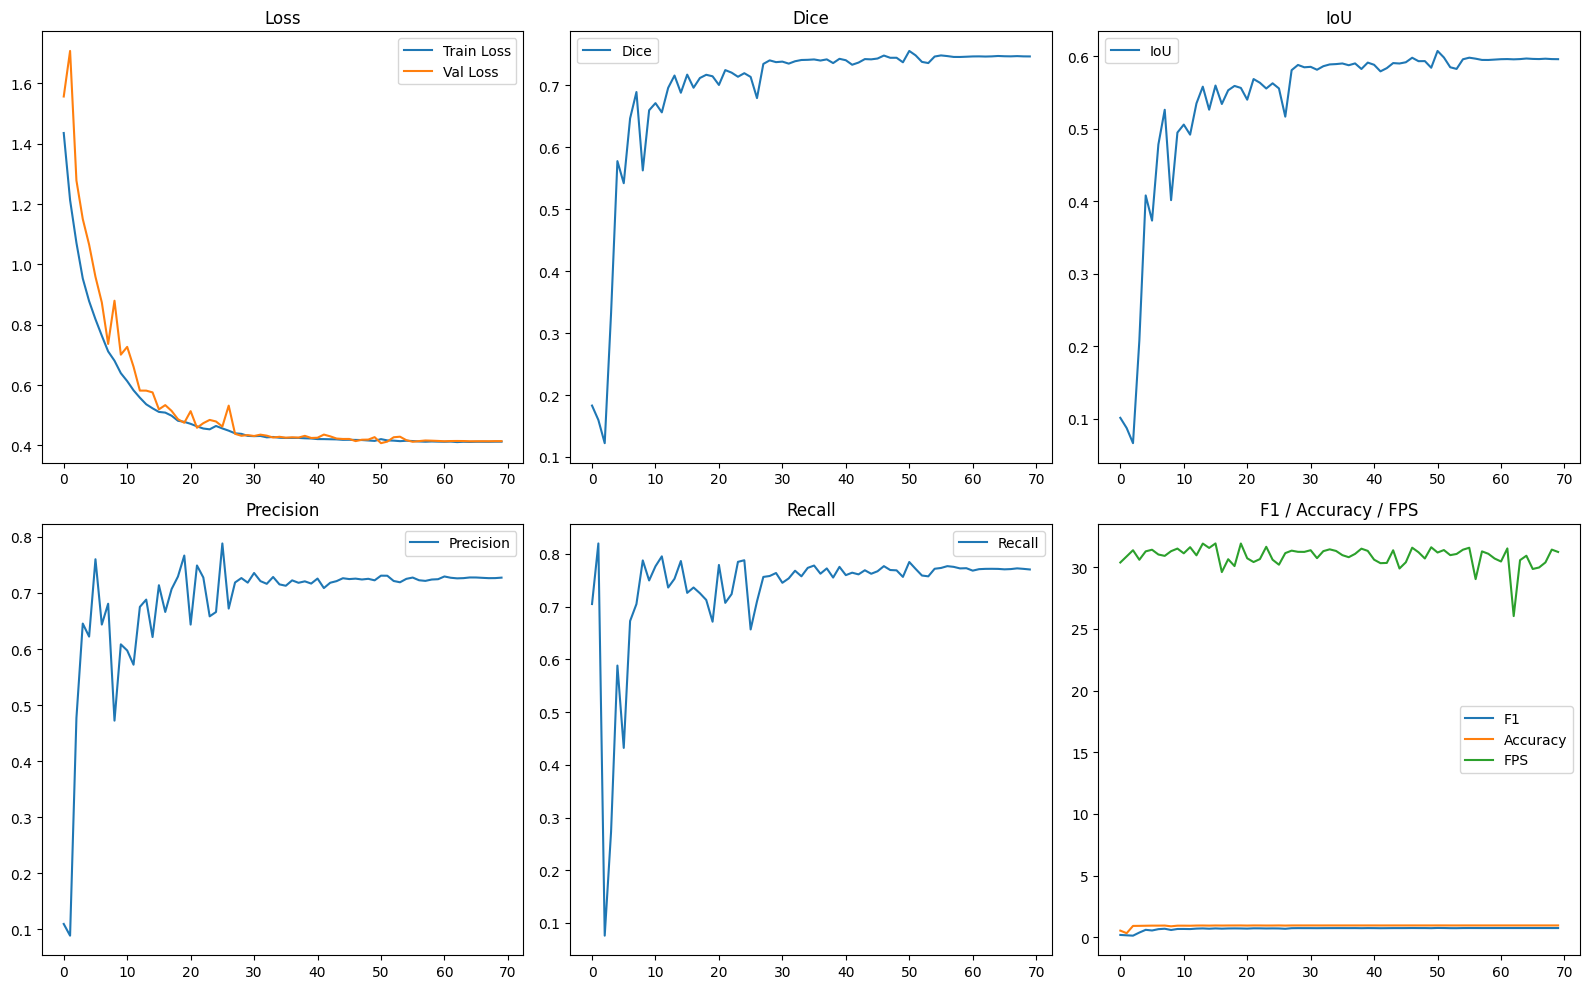

In [40]:
# Cell No 12
plt.figure(figsize=(16,10))

# Loss
plt.subplot(2,3,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

# Dice
plt.subplot(2,3,2)
plt.plot(history["val_dice"], label="Dice")
plt.title("Dice")
plt.legend()

# IoU
plt.subplot(2,3,3)
plt.plot(history["val_iou"], label="IoU")
plt.title("IoU")
plt.legend()

# Precision
plt.subplot(2,3,4)
plt.plot(history["val_precision"], label="Precision")
plt.title("Precision")
plt.legend()

# Recall
plt.subplot(2,3,5)
plt.plot(history["val_recall"], label="Recall")
plt.title("Recall")
plt.legend()

# F1 + Accuracy + FPS (optional overlay)
plt.subplot(2,3,6)
plt.plot(history["val_f1"], label="F1")
plt.plot(history["val_acc"], label="Accuracy")
plt.plot(history["val_fps"], label="FPS")
plt.title("F1 / Accuracy / FPS")
plt.legend()

plt.tight_layout()
plt.show()

## Load best weights for inference

In [41]:
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()
print("Loaded model weights from", save_path)

Loaded model weights from /kaggle/working/best_unet.pth


## Prediction visualization and overlay

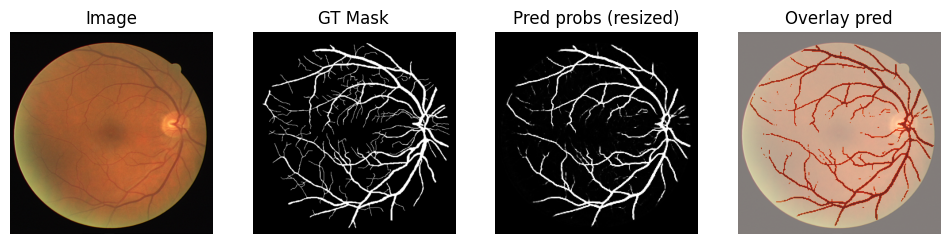

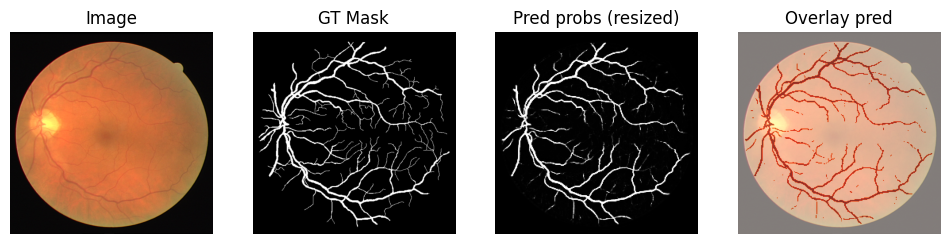

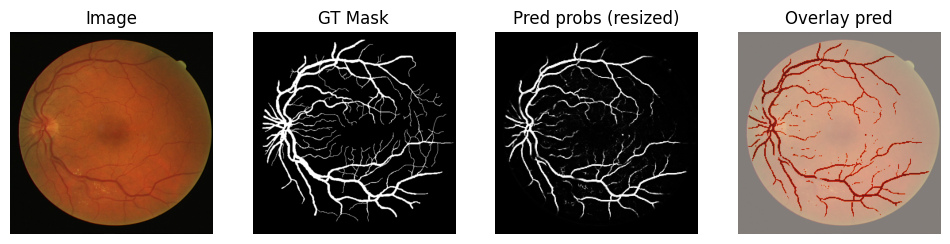

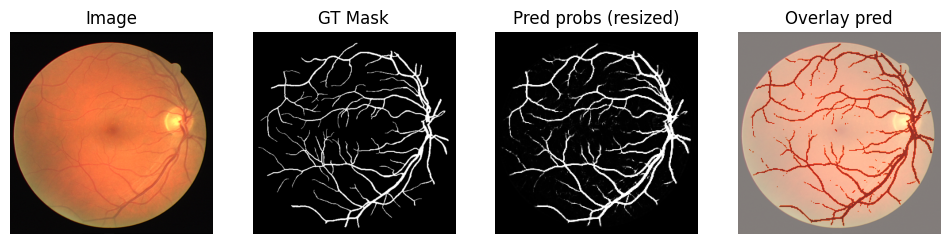

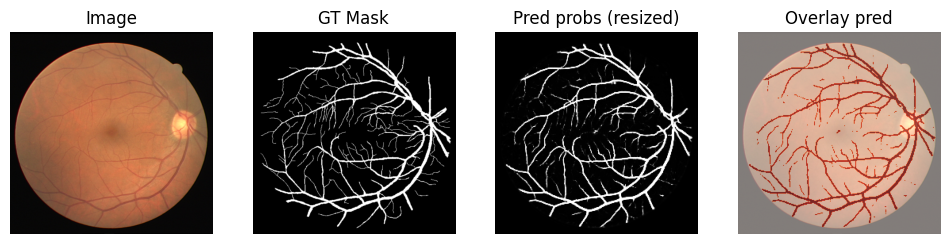

In [42]:
def predict_and_show(img_path, mask_path=None, threshold=0.5):
    orig = Image.open(img_path).convert("RGB")
    resized = orig.resize(resize, resample=Image.BILINEAR)
    img_arr = np.array(resized).astype(np.float32) / 255.0
    tensor = torch.tensor(img_arr.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(tensor)
        probs = torch.sigmoid(out).squeeze().cpu().numpy()
    pred_bin = (probs > threshold).astype(np.uint8)
    pred_full = Image.fromarray((pred_bin*255).astype(np.uint8)).resize(orig.size, resample=Image.NEAREST)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(orig); plt.title("Image"); plt.axis("off")
    if mask_path:
        gt = Image.open(mask_path).convert("L")
        plt.subplot(1,4,2); plt.imshow(gt, cmap="gray"); plt.title("GT Mask"); plt.axis("off")
    else:
        plt.subplot(1,4,2); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(probs, cmap="gray"); plt.title("Pred probs (resized)"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(orig); plt.imshow(pred_full, cmap="Reds", alpha=0.5); plt.title("Overlay pred"); plt.axis("off")
    plt.show()

# show 5 random test examples (paired by basename)
test_keys = sorted(list(set(os.listdir(test_img_path)) & set(os.listdir(test_mask_path))))
for k in random.sample(test_keys, min(5, len(test_keys))):
    predict_and_show(os.path.join(test_img_path, k), os.path.join(test_mask_path, k))

## Error map for one sample

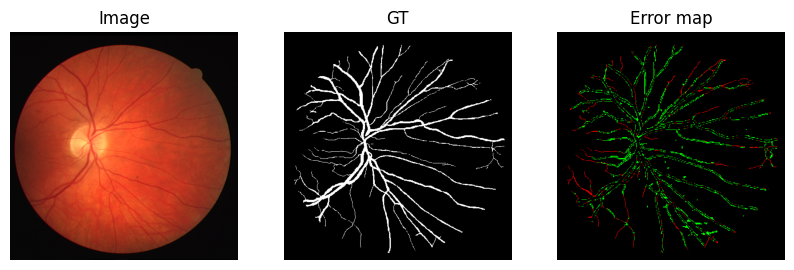

In [45]:
def error_map(img_path, mask_path, threshold=0.5):
    orig = Image.open(img_path).convert("RGB")
    resized = orig.resize(resize, resample=Image.BILINEAR)
    img_arr = np.array(resized).astype(np.float32) / 255.0
    tensor = torch.tensor(img_arr.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(tensor)
        probs = torch.sigmoid(out).squeeze().cpu().numpy()
    pred_bin = (probs > threshold).astype(np.uint8)
    pred_full = Image.fromarray((pred_bin*255).astype(np.uint8)).resize(orig.size, resample=Image.NEAREST)
    gt = (np.array(Image.open(mask_path).convert("L")) > 127).astype(np.uint8)
    pred_np = (np.array(pred_full) > 127).astype(np.uint8)
    err = pred_np.astype(int) - gt.astype(int)  # -1 miss, 0 ok, 1 false pos
    vis = np.zeros((*err.shape, 3), dtype=np.float32)
    vis[err == -1] = [1, 0, 0]  # misses red
    vis[err == 1] = [0, 1, 0]   # false pos green

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(orig); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gt, cmap="gray"); plt.title("GT"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(vis); plt.title("Error map"); plt.axis("off")
    plt.show()

# visualize error map for a random test sample
if test_keys:
    k = random.choice(test_keys)
    error_map(os.path.join(test_img_path, k), os.path.join(test_mask_path, k))

## Save some predictions for inspection

In [46]:
out_dir = "/kaggle/working/predictions"
os.makedirs(out_dir, exist_ok=True)
sample_keys = random.sample(test_keys, min(20, len(test_keys)))
for i, k in enumerate(sample_keys):
    img_path = os.path.join(test_img_path, k)
    mask_path = os.path.join(test_mask_path, k)
    orig = Image.open(img_path).convert("RGB")
    resized = orig.resize(resize, resample=Image.BILINEAR)
    tensor = torch.tensor(np.array(resized).astype(np.float32).transpose(2,0,1)/255.0).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(tensor)
        probs = torch.sigmoid(out).squeeze().cpu().numpy()
    pred_bin = (probs > 0.5).astype(np.uint8)
    pred_full = Image.fromarray((pred_bin*255).astype(np.uint8)).resize(orig.size, resample=Image.NEAREST)
    pred_full.save(os.path.join(out_dir, f"pred_{i}_{k}"))
print("Saved predictions to", out_dir)

Saved predictions to /kaggle/working/predictions


# Final checklist and troubleshooting
- If predictions are blank or full, ensure the inference preprocessing matches training. Check resize and normalization.
- If mask overlay is misaligned, filenames are mismatched. Use basename matching like this notebook.
- If validation metrics are worse than original, load the original weights. Metric drop usually means different preprocessing or missing normalization.
- If GPU OOM, reduce batch_size or reduce resize.
- If you want me to merge these changes directly into your uploaded Notebook 1 file and match exact variable names present there, say "match notebooks" and I will produce a patch adapted to your notebook internals